# Soft Margin SVM Code and Support Vector Analysis

### Necessary Imports

In [1]:
!pip install pillow-heif
import pandas as pd
import os
from google.colab import drive
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import time
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import math
from scipy.spatial.distance import cdist
import seaborn as sns
# To open heif files
import pillow_heif
import time
pillow_heif.register_heif_opener()
drive.mount('/content/drive')
MY_DRIVE_PATH = "/content/drive/MyDrive/MLProject_2"
DATA_FOLDER = os.path.join(MY_DRIVE_PATH, 'Data google sheet')
PROCESSED_CSV_FILE = os.path.join(DATA_FOLDER, 'Processed_Fruits_Data.csv')
ONEHOT_CSV_FILE = os.path.join(DATA_FOLDER, 'One_Hot_Processed_Fruits_Data.csv')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.4 MB/s eta 0:00:00
Mounted at /content/drive


### Creating the dataset
This part is identical with our logistic regression code

In [2]:
# Initialize
df = pd.read_csv(ONEHOT_CSV_FILE, sep = ";")
random.seed(42)
# Preprocessing

# Keeping number of items same for each class
N_TRAIN = 450
N_TEST  = 150
N_TOTAL = N_TRAIN + N_TEST

train_dfs = []
test_dfs = []

categories = ['banana', 'tomato', 'apple', 'orange', 'tangerine']
for category in categories:
    subset = df[df["Fruit"] == category]
    subset = subset.sample(N_TOTAL, random_state=42).reset_index(drop=True)

    train_subset = subset.iloc[:N_TRAIN]
    test_subset  = subset.iloc[N_TRAIN : N_TOTAL]

    train_dfs.append(train_subset)
    test_dfs.append(test_subset)
# Histrogram normalization
for idx in range(len(df)):
    df_image_cols = [column for column in df.columns if "img" in column]
    hist_values = df.loc[idx, df_image_cols].values
    total = hist_values.sum()

    # Normalize to proportions (avoid division by zero)
    if total > 0:
        df.loc[idx, df_image_cols] = hist_values / total
    else:
        df.loc[idx, df_image_cols] = 0  # All zeros if empty

# 3. Concatenating and shuffling
df_train = pd.concat(train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
df_test  = pd.concat(test_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
df_train_unnormalized = df_train.copy()

print(f"Train Shape: {df_train.shape}")
print(f"Test Shape:  {df_test.shape}")

# Normalization
numerical_cols = ["Weight","Price"]
image_cols = [column for column in df_train.columns if "img" in column]
text_cols = [column for column in df_train.columns if "text" in column]
categorical_cols = [column for column in df_train.columns if (column not in numerical_cols + image_cols + text_cols) and (column != "Fruit")] # We don't want the target
columns_to_normalize = numerical_cols + image_cols + text_cols

epsilon = 1e-8  # To prevent division by zero
for column in columns_to_normalize:
    mean = df_train[column].mean()
    std = df_train[column].std()
    df_train[column] = (df_train[column] - mean) / (std + epsilon)
    df_test[column]  = (df_test[column] - mean) / (std + epsilon)

# Removing the target
target_col = 'Fruit'
metadata_cols = ["Image_path", "Text", "Label"]

X_train = df_train.drop(columns=[target_col] + metadata_cols)
y_train = df_train[target_col]

X_test = df_test.drop(columns=[target_col] + metadata_cols)
y_test = df_test[target_col]


Train Shape: (2250, 496)
Test Shape:  (750, 496)


## Dual Soft Margin SVM

Our approach is mostly inspired by this site : https://domino.ai/blog/fitting-support-vector-machines-quadratic-programming

and notes from CMU : https://www.cs.cmu.edu/~aarti/Class/10701_Spring21/Lecs/svm_dual_kernel_inked.pdf

Dual SVM is defined in our slides like this:
$$
\begin{aligned}
\max_{\alpha \in \mathbb{R}^N} \quad & \sum_{n=1}^{N} \alpha_n - \frac{1}{2} \sum_{n=1}^{N} \sum_{m=1}^{N} y_n y_m \alpha_n \alpha_m \mathbf{x}_n^T \mathbf{x}_m \\
\text{subject to:} \quad & \sum_{n=1}^{N} y_n \alpha_n = 0 \\
& \alpha_n \geq 0 \quad n = 1, \dots, N
\end{aligned}
$$

However we need to make it soft margin SVM. Thankfully, converting dual hard margin SVM to soft margin SVM needs only one modification. We just need to convert $\alpha_n \geq 0 \quad n = 1, \dots, N$ line to $C \geq \alpha_n \geq 0 \quad n = 1, \dots, N$. One can clearly see that if $C \to \infty$ and these constraints become identical to hard margin problem.

Thus making our objective :
$$
\begin{aligned}
\max_{\alpha \in \mathbb{R}^N} \quad & \sum_{n=1}^{N} \alpha_n - \frac{1}{2} \sum_{n=1}^{N} \sum_{m=1}^{N} y_n y_m \alpha_n \alpha_m \mathbf{x}_n^T \mathbf{x}_m \\
\text{subject to:} \quad & \sum_{n=1}^{N} y_n \alpha_n = 0 \\
& C \geq \alpha_n \geq 0 \quad n = 1, \dots, N
\end{aligned}
$$.

## cvxopt Implementation

We are using cvxopt as our quadratic programming solver. This library expects the problem to be defined as:
$$
\begin{aligned}
\min \quad & \frac{1}{2}\mathbf{x}^T \mathbf{P} \mathbf{x} + \mathbf{q}^T \mathbf{x} \\
\text{subject to} \quad & \mathbf{A}\mathbf{x} = \mathbf{b} \\
& \mathbf{G}\mathbf{x} \leq \mathbf{h}
\end{aligned}
$$

To make our implementation match the library, we transform the SVM dual problem:

$$
\max_{\alpha \in \mathbb{R}^N} \quad \sum_{n=1}^{N} \alpha_n - \frac{1}{2} \sum_{n=1}^{N} \sum_{m=1}^{N} y_n y_m \alpha_n \alpha_m \mathbf{x}_n^T \mathbf{x}_m
$$

We rewrite by factoring the labels:

$$
\max_{\alpha \in \mathbb{R}^N} \quad \sum_{n=1}^{N} \alpha_n - \frac{1}{2} \sum_{n=1}^{N} \sum_{m=1}^{N} \alpha_n \alpha_m (y_n \mathbf{x}_n^T \mathbf{x}_m y_m)
$$

If we let $\mathbf{H} = \mathbf{y}\mathbf{X}$, then our objective becomes:

$$
\begin{aligned}
\min_{\alpha} \quad & \frac{1}{2}\alpha^T H\alpha - 1^T\alpha \\
\text{such that} \quad & y^T\alpha = 0 \\
& -\alpha_i \leq 0 \quad \forall i \\
& \alpha_i \leq C \quad \forall i
\end{aligned}
$$

Therefore our vectors are:


*   $\mathbf{P} = \mathbf{H} = (y \odot X) \cdot (y \odot X)^T, (N \times N \text{ matrix})$
*   $\mathbf{q} = -\mathbf{1}_N$ (vector of negative ones, length $N$)
*   $\mathbf{A} = \mathbf{y}^T$ (equality constraint, $1 \times N$)
*   $\mathbf{b} = 0$ (scalar)
*   $\mathbf{G} = \begin{bmatrix} -\mathbf{I}_N \\ \mathbf{I}_N \end{bmatrix}$ (inequality constraints, $2N \times N$)
*   $\mathbf{h} = \begin{bmatrix} \mathbf{0}_N \\ C \cdot \mathbf{1}_N \end{bmatrix}$ (inequality bounds, $2N \times 1$)


We have chosen C = 1 for this implementation and used One vs All approach.

In [3]:
def train_svm(X_train, y_train, C=1):
  X = X_train.values
  y = y_train.reshape(-1, 1)
  n = X.shape[0]
  # Objective
  H = np.dot(y*X, (y*X).T) # a^T.H.a
  q = np.repeat([-1.0], n)[..., None] # (-1)^T
  # y.alpha = 0
  A = y.reshape(1, -1)
  b = 0.0
  # Inequality constraints
  g_first = -(np.eye(n)) # -alpha_i <= 0
  g_second = np.eye(n)   # alpha_i <= C
  G = np.vstack((g_first,g_second))
  # Inequality rhs
  h_first = np.zeros(n)
  h_second = C * np.ones(n)
  h = np.concatenate((h_first, h_second))

  # Turning of the logs
  solvers.options['show_progress'] = False

  # cvxopt parameters
  P = matrix(H)
  q = matrix(q)
  G = matrix(G)
  h = matrix(h)
  A = matrix(A)
  b = matrix(b)
  sol = solvers.qp(P, q, G, h, A, b)
  alphas = np.array(sol["x"])
  w = np.dot((y * alphas).T, X)[0]
  S = (alphas > 1e-5).flatten()
  b = np.mean(y[S] - np.dot(X[S], w.reshape(-1,1)))

  # Accuracy calculation
  train_scores = np.dot(X, w) + b
  train_preds = np.where(train_scores >= 0, 1.0, -1.0)
  train_acc = np.mean(train_preds.flatten() == y.flatten())

  #Support vectors
  is_positive_class = (y.flatten() == 1.0)
  is_on_positive_margin = np.abs(train_scores - 1.0) < 1e-1
  #positive_mask = S & is_positive_class & is_on_positive_margin
  positive_mask = S & is_positive_class
  positive_support_vectors = X_train[positive_mask]

  is_negative_class = (y.flatten() == -1.0)
  is_on_negative_margin = np.abs(train_scores + 1.0) < 1e-1
  #negative_mask = S & is_negative_class & is_on_negative_margin
  negative_mask = S & is_negative_class
  negative_support_vectors = X_train[negative_mask]

  # All support vectors
  all_support_vectors = X_train[S]

  # Finding most distant data
  positive_distances = np.abs(train_scores[is_positive_class] - 1.0)
  most_distant_positive_index = np.argmax(positive_distances)

  negative_distances = np.abs(train_scores[is_negative_class] + 1.0)
  most_distant_negative_index = np.argmax(negative_distances)

  return {
      "w": w,
      "b": b,
      "p_support_vectors": positive_support_vectors,
      "n_support_vectors": negative_support_vectors,
      "support_vectors": all_support_vectors,
      "most_distant_positive_index": most_distant_positive_index,
      "most_distant_negative_index": most_distant_negative_index,
      "train_acc": train_acc,
  }

def fit_softmargin_svm_one_vs_all(X_train, y_train, class_name, C=1):
    y_train_binary = np.where(y_train == class_name, 1.0, -1.0)
    return train_svm(X_train, y_train_binary, C)

### Training the models in One vs All convention

In [4]:
C = 1
# One vs all part
models = {}
print("Starting training")
start_time = time.time()
for category in categories:
  model_dict = fit_softmargin_svm_one_vs_all(X_train, y_train, category, C)
  models[category] = model_dict
print(f"Training finished in {time.time() - start_time:.2f} seconds")

Starting training
Training finished in 138.55 seconds


# Plotting Support Vectors (16 on each side)

In [5]:
def read_image(path):
    try:
        img = Image.open(path)
        return np.array(img)
    except Exception as e:
        print(f"Image error {path}: {e}")
        return None

# Loop through each category
for category in categories:
    print(f"\n===== Processing Category: {category} =====")
    p_indices = models[category]['p_support_vectors'].index
    n_indices = models[category]['n_support_vectors'].index

    # Columns 0-3: Positive SVs
    # Columns 4-7: Negative SVs
    rows = 4
    cols = 8

    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    fig.suptitle(f"Category: {category} (Left: Positive SVs | Right: Negative SVs)", fontsize=14, y=1.02)
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            ax.axis('off')
            is_positive_section = c < 4
            list_idx = (r * 4) + (c if is_positive_section else (c - 4))
            target_indices = p_indices if is_positive_section else n_indices

            if list_idx < len(target_indices):
                df_idx = target_indices[list_idx]
                path = df_train.loc[df_idx, "Image_path"]
                img = read_image(path)
                ax.imshow(img)

            # Vertical divider between two groups
            if c == 3:
                line = plt.Line2D([1.1, 1.1], [0, 1], transform=ax.transAxes, color="black", linewidth=1)
                line.set_clip_on(False)
                ax.add_artist(line)

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [6]:
for category in categories:
    svs = models[category]['support_vectors']
    print(f"{category} has {len(svs)} support vectors.")

banana has 108 support vectors.
tomato has 121 support vectors.
apple has 195 support vectors.
orange has 143 support vectors.
tangerine has 110 support vectors.


# Support Vector Analysis

First of all, from homework 1 we realized that image features are less discriminative then our other attributes. So, looking at the support vectors visually won't tell us much about our model since it mostly uses other attributes. However, we can still extract some information.

Firstly, we can see that negative support vectors contain images from all other categories. This is because we used one vs all approach here and even though the model learns to distinguish only one class, it still acquired some info about other classes as well.

Secondly, we see that most of the support vectors are AI generated. We know that support vectors are the ones that model is struggling to classify. AI generated photos seem more bright than its real-world counterparts so the model probably regards their histogram as an outlier. In addition, we have generated attributes of the AI data from normal distribution on sample mean and variance. We can think that these examples might be pulled from the far end of the distribution.

About real pictures, we see that they have difficult lighting conditions. Let's anaylze it case by case:

### **Banana**
This has 2 real images, and they have shadow on top of them.
### **Tomato**
While images seem normal, we see that this is a small tomato so it could be hard to classify because of its low weight.
### **Apple**
One image is taken by a flashlight in the dark, one is in a teapot and one is on top of a bright blue recycling bin.
### **Orange**
We have only one real picture and its colors are far from normal
### **Tangerine**
For the two real images, they are all on top of a bright blue notebook and they have different colors than normal. One is green and one is yellow.

# Plotting farthest points

===== Category: banana =====
Train Accuracy: 1.0


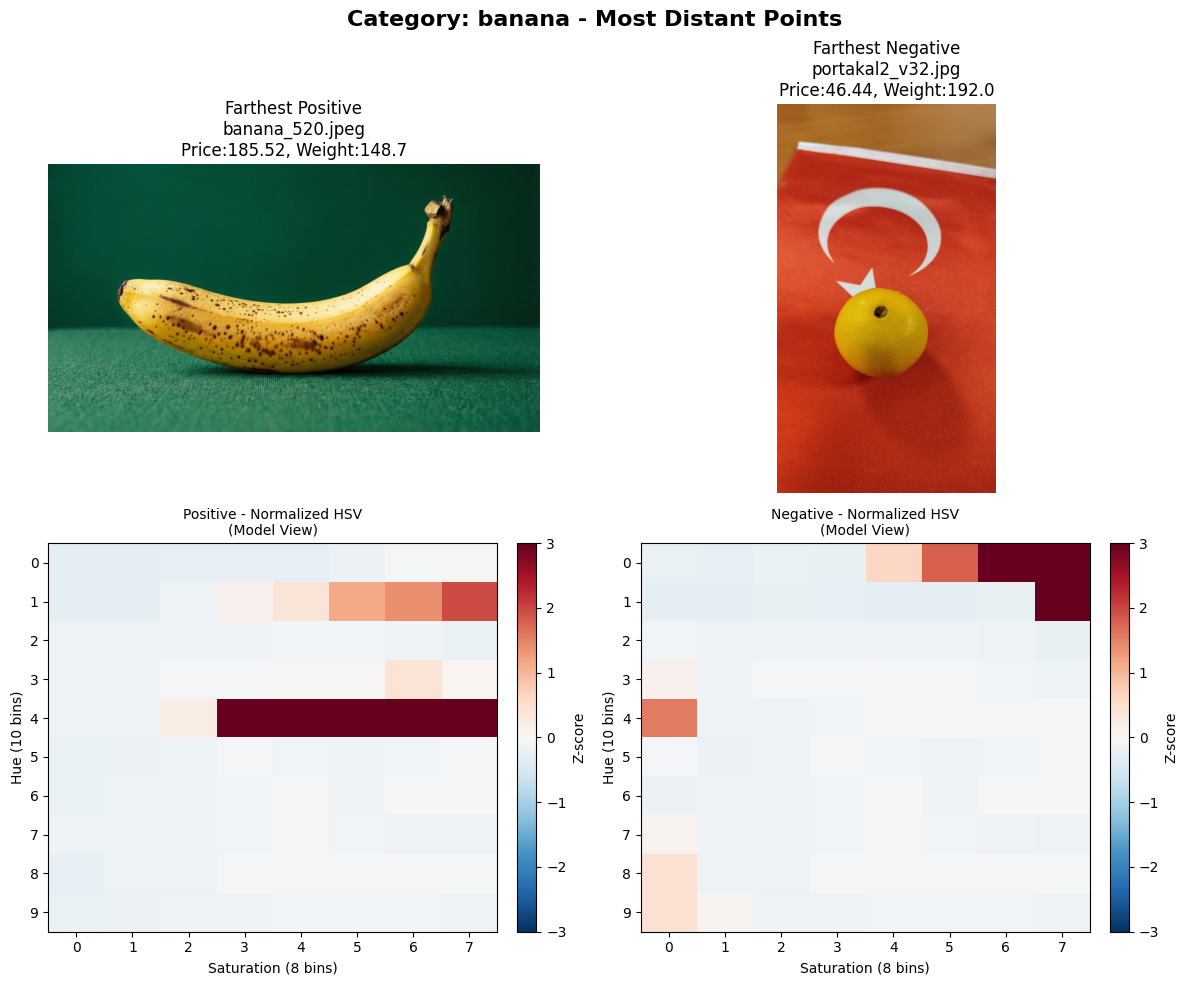

===== Category: tomato =====
Train Accuracy: 1.0


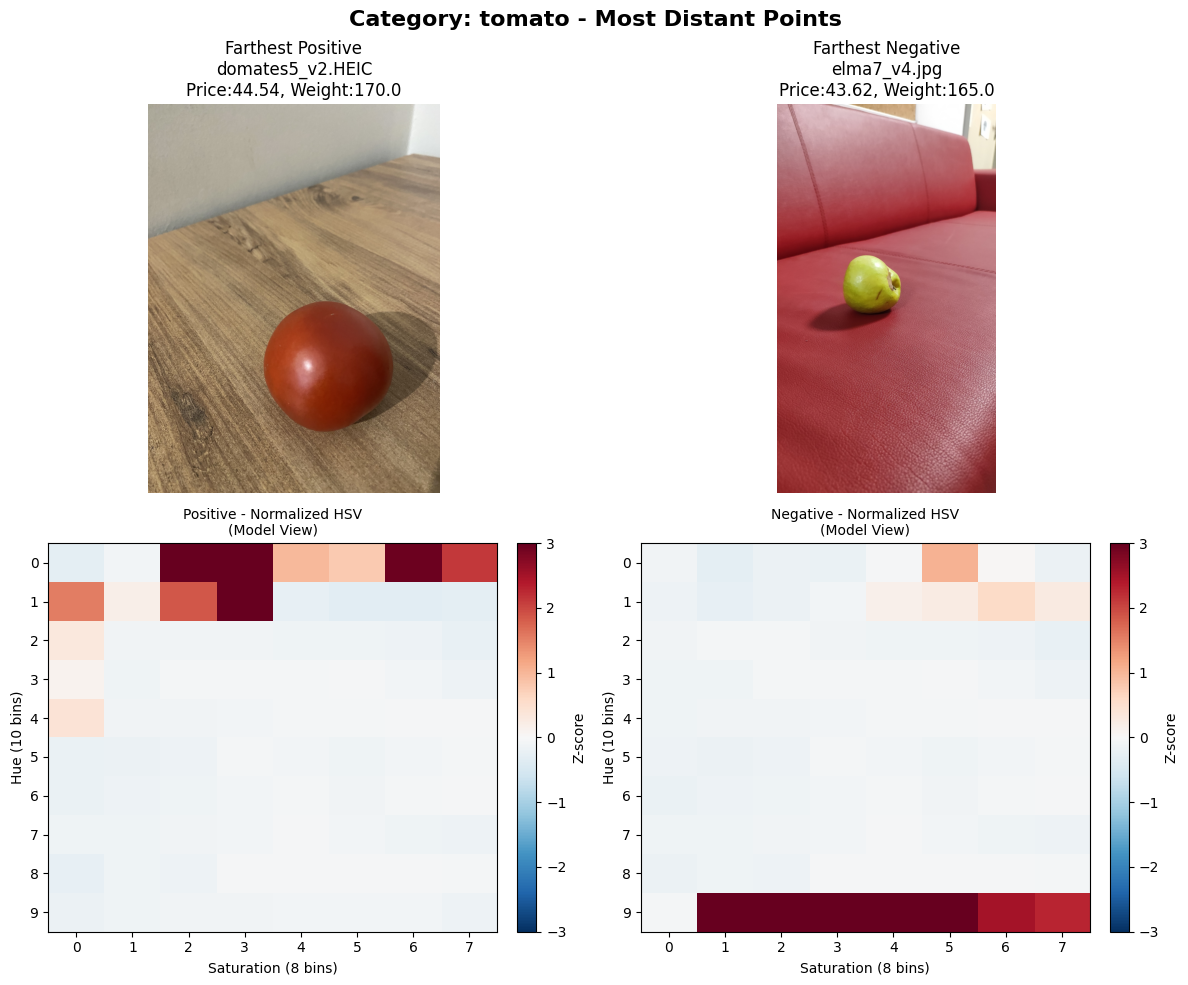

===== Category: apple =====
Train Accuracy: 1.0


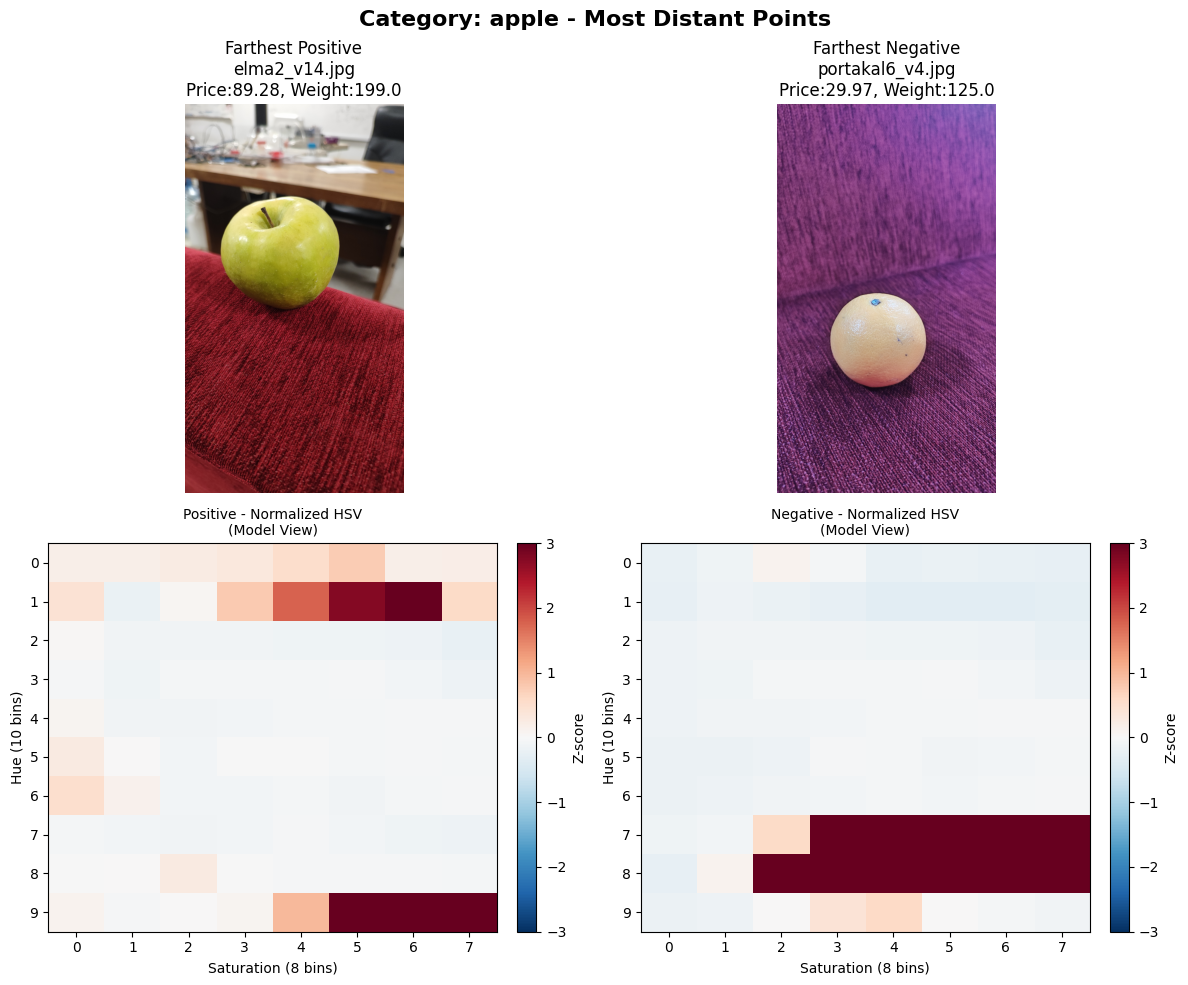

===== Category: orange =====
Train Accuracy: 0.9995555555555555


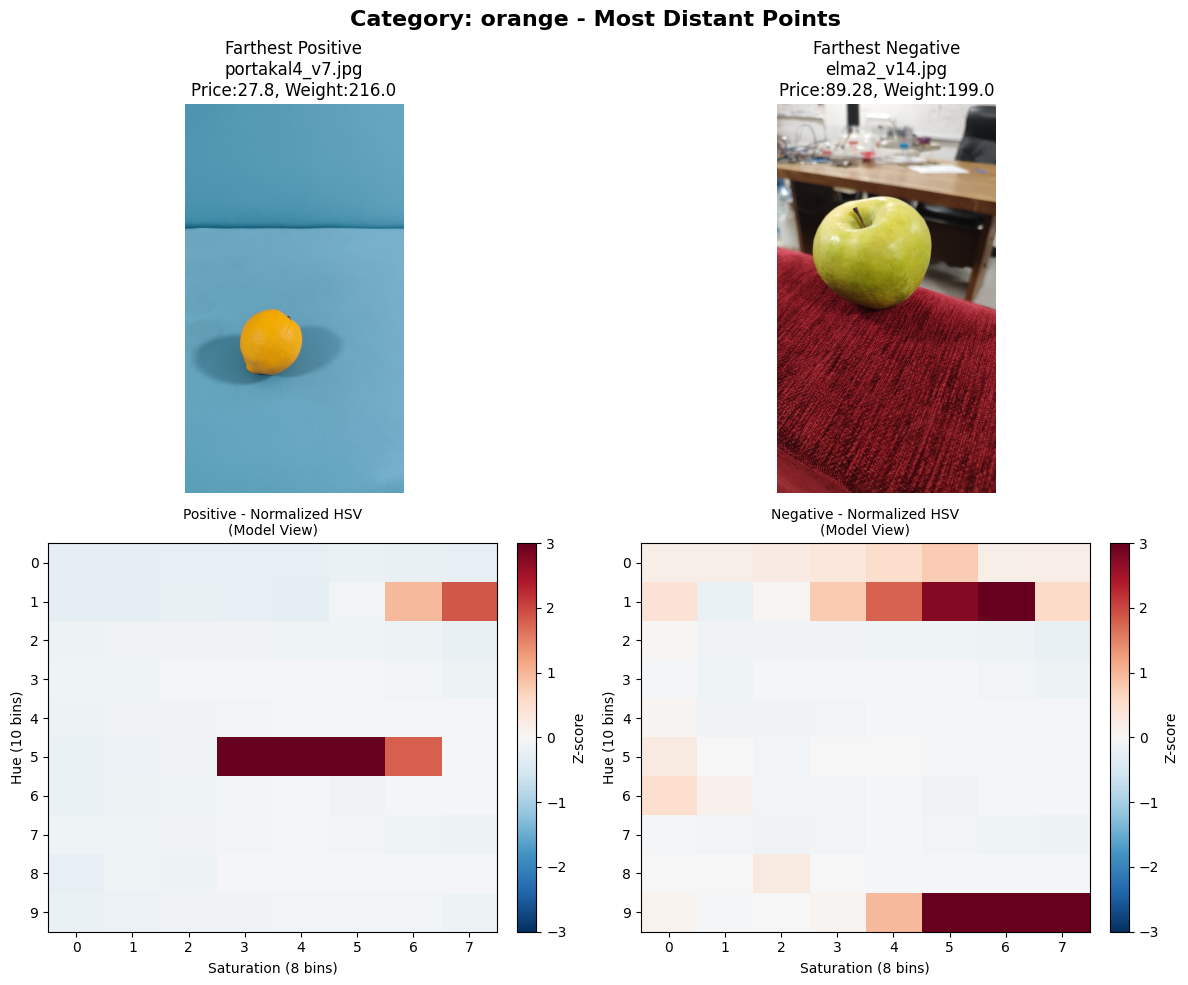

===== Category: tangerine =====
Train Accuracy: 1.0


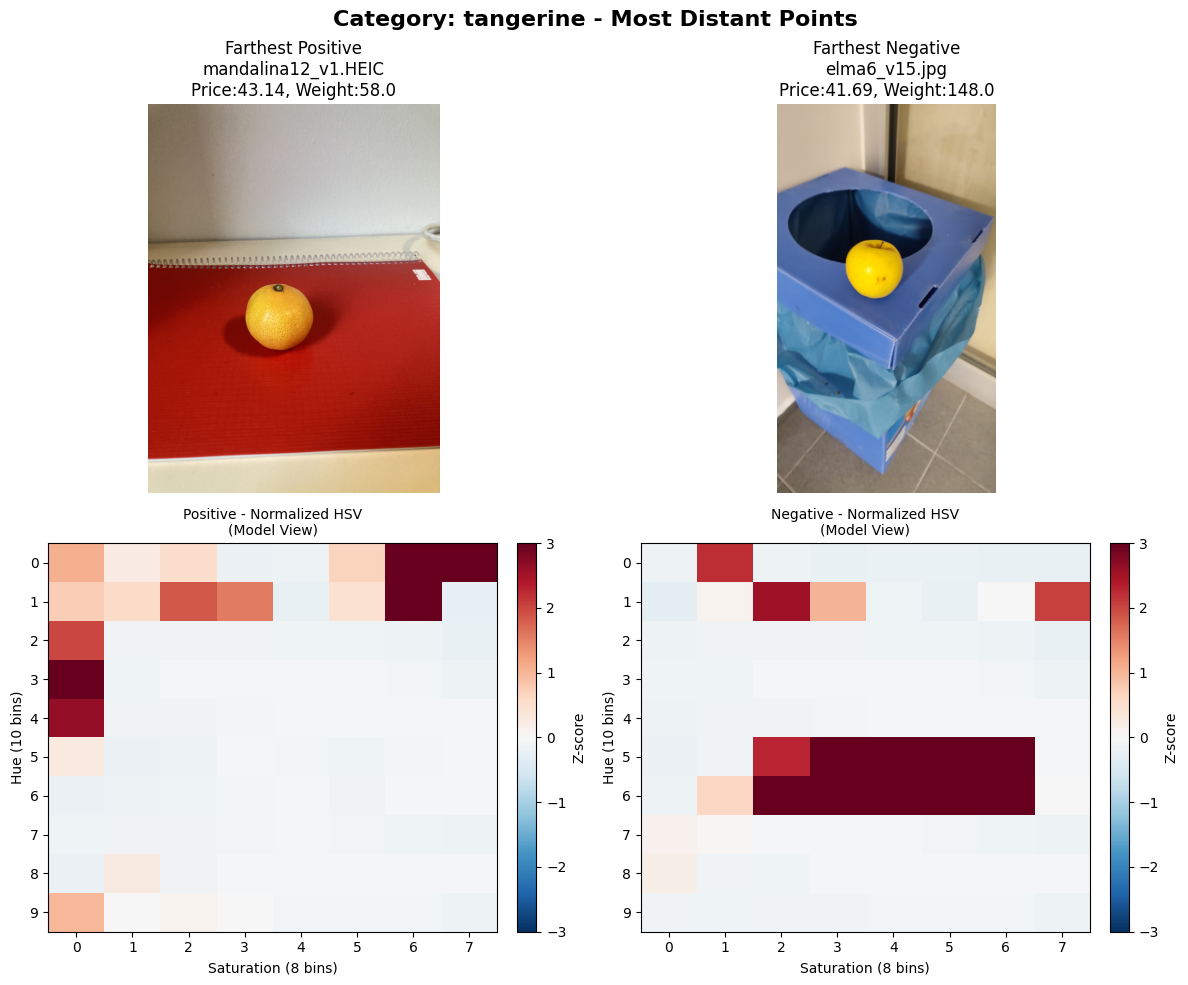

In [7]:
# Get image column names
image_cols = [column for column in df_train.columns if "img" in column]

for category in categories:
    print(f"===== Category: {category} =====")
    print(f"Train Accuracy: {models[category]['train_acc']}")

    # Get indices
    positive_indices = df_train_unnormalized[y_train == category].index
    negative_indices = df_train_unnormalized[y_train != category].index
    p_farthest_relative = models[category]['most_distant_positive_index']
    n_farthest_relative = models[category]['most_distant_negative_index']

    # Get rows
    p_row = df_train_unnormalized.loc[positive_indices[p_farthest_relative]]
    n_row = df_train_unnormalized.loc[negative_indices[n_farthest_relative]]

    p_global = positive_indices[p_farthest_relative]
    n_global = negative_indices[n_farthest_relative]

    p_farthest = models[category]['most_distant_positive_index']
    n_farthest = models[category]['most_distant_negative_index']

    p_path = p_row["Image_path"]
    n_path = n_row["Image_path"]
    p_price = p_row["Price"]
    p_weight = p_row["Weight"]
    n_price = n_row["Price"]
    n_weight = n_row["Weight"]

    # Get normalized histograms from df_train using image columns
    p_hist = df_train.loc[p_global, image_cols].values.astype(float)
    n_hist = df_train.loc[n_global, image_cols].values.astype(float)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"Category: {category} - Most Distant Points", fontsize=16, fontweight='bold')

    # Positive image
    img_p = read_image(p_path)
    axes[0, 0].imshow(img_p)
    axes[0, 0].set_title(f"Farthest Positive\n{p_path.split('/')[-1]}\nPrice:{p_price}, Weight:{p_weight}")
    axes[0, 0].axis('off')

    # Negative image
    img_n = read_image(n_path)
    axes[0, 1].imshow(img_n)
    axes[0, 1].set_title(f"Farthest Negative\n{n_path.split('/')[-1]}\nPrice:{n_price}, Weight:{n_weight}")
    axes[0, 1].axis('off')

    # Positive histogram
    p_hist_2d = p_hist.reshape(10, 8)
    im1 = axes[1, 0].imshow(p_hist_2d, cmap='RdBu_r', aspect='auto', vmin=-3, vmax=3)
    axes[1, 0].set_xlabel('Saturation (8 bins)', fontsize=10)
    axes[1, 0].set_ylabel('Hue (10 bins)', fontsize=10)
    axes[1, 0].set_title('Positive - Normalized HSV\n(Model View)', fontsize=10)
    axes[1, 0].set_xticks(range(8))
    axes[1, 0].set_yticks(range(10))
    plt.colorbar(im1, ax=axes[1, 0], fraction=0.046, pad=0.04, label='Z-score')

    # Negative histogram
    n_hist_2d = n_hist.reshape(10, 8)
    im2 = axes[1, 1].imshow(n_hist_2d, cmap='RdBu_r', aspect='auto', vmin=-3, vmax=3)
    axes[1, 1].set_xlabel('Saturation (8 bins)', fontsize=10)
    axes[1, 1].set_ylabel('Hue (10 bins)', fontsize=10)
    axes[1, 1].set_title('Negative - Normalized HSV\n(Model View)', fontsize=10)
    axes[1, 1].set_xticks(range(8))
    axes[1, 1].set_yticks(range(10))
    plt.colorbar(im2, ax=axes[1, 1], fraction=0.046, pad=0.04, label='Z-score')

    plt.tight_layout()
    plt.show()

# Comparison of Support Vectors with Farthest Points

Again, visual comparison will not tell us much since our model mostly uses other attributes. But we can still analyze them a little bit.

### **Banana**
Most "banana" data point actually looks similar to support vector bananas. However its price is higher than most points, thus making sure that it is a banana.

### **Tomato**

From the visuals, price and weight, we cannot tell why this is the most tomato of them all and most negative points has more red pixels than our tomato. This probably shows that our model thinks that too much red is also an indicator of not tomato and most importantly, it shows that our model uses categorical or textual feature more.

### **Apple**

We can deduce some information from the picture. The picture has mostly red and green pixels, which are the pixels that are mostly seen in apple images. Also its weight is large making it easy to classify.

### **Orange**

This image is interesting because it includes mostly blue pixels, which are not related to orange. Probably its low price and high weight detone it as an orange. "Most apple" point is now the "least orange" point because it includes mostly red and green pixels.

### **Tangerine**

This image has a tangerine on top of a blue notebook. Again even though it looks similar to support vector images, it has a low weight, ensuring that it is a tangerine.



# Calculating Support Vector Distances and Confusion Matrix

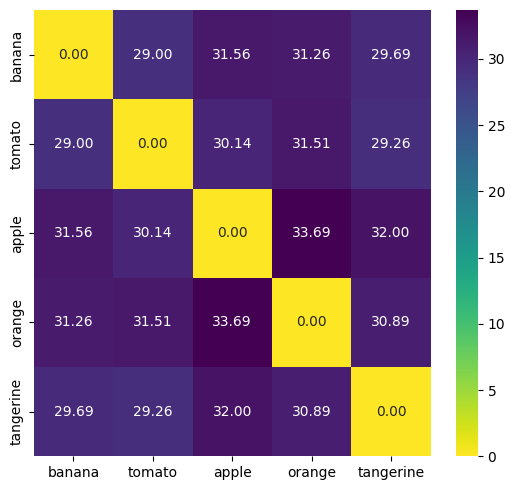

In [8]:
mean_dist_matrix = np.zeros((len(categories), len(categories)))
min_dist_matrix = np.zeros((len(categories), len(categories)))
for i, class_1 in enumerate(categories):
    for j, class_2 in enumerate(categories):
        if i == j:
            continue

        # Positive support vectors
        sv_1 = models[class_1]['p_support_vectors'].values
        sv_2 = models[class_2]['p_support_vectors'].values

        # Euclidean distance calculation
        dists = cdist(sv_1, sv_2, metric='euclidean')

        avg_dist = np.mean(dists)
        mean_dist_matrix[i, j] = avg_dist

        min_dist = np.min(dists)
        min_dist_matrix[i, j] = min_dist

plt.figure(figsize=(5.5, 5))
sns.heatmap(
    mean_dist_matrix,
    xticklabels=categories,
    yticklabels=categories,
    annot=True,
    fmt=".2f",
    cmap="viridis_r",
)

plt.tight_layout()

plt.show()

SVM Accuracy: 97.07%


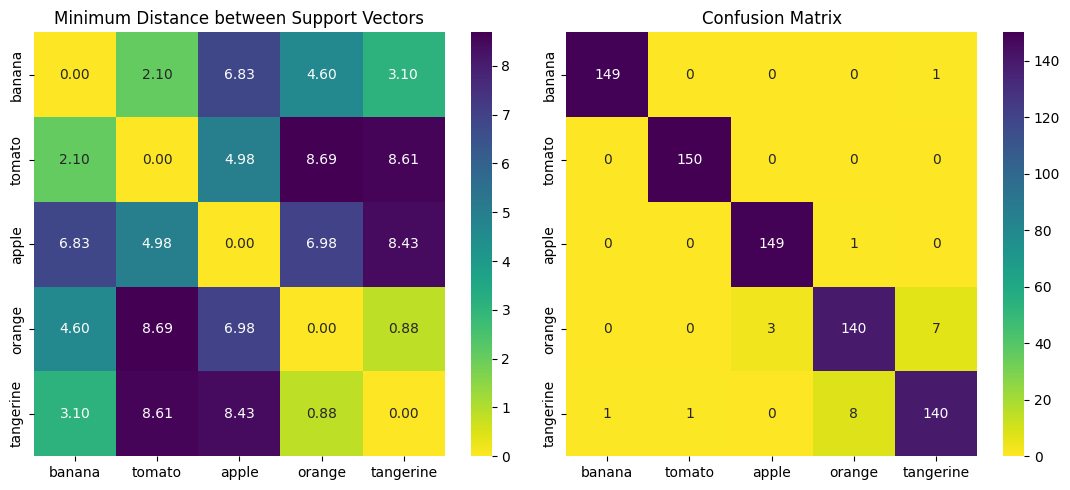

In [9]:
y_pred = []
X_test_np = X_test.values

for i in range(len(y_test)):
    x = X_test_np[i]
    scores = {}
    # Calculating score for each category
    for category in categories:
        w = models[category]['w']
        b = models[category]['b']
        score = np.dot(x, w) + b
        scores[category] = score

    # One with the highest score is the prediction
    predicted_category = max(scores, key=scores.get)
    y_pred.append(predicted_category)

conf_matrix = np.zeros((len(categories), len(categories)),dtype=np.int16)
for true_label, pred_label in zip(y_test, y_pred):
    conf_matrix[categories.index(true_label), categories.index(pred_label)] += 1


fig, axes = plt.subplots(1, 2, figsize=(11, 5))
# Plot 1: Minimum distance heatmap
sns.heatmap(
    min_dist_matrix,
    xticklabels=categories,
    yticklabels=categories,
    annot=True,
    fmt=".2f",
    cmap="viridis_r",
    ax=axes[0]
)
axes[0].set_title("Minimum Distance between Support Vectors")

sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap="viridis_r",
    xticklabels = categories,
    yticklabels=categories,
    ax=axes[1])
axes[1].set_title("Confusion Matrix")

accuracy = np.trace(conf_matrix) / np.sum(conf_matrix) # Sum of diagonals / Whole array

print(f"SVM Accuracy: {accuracy:.2%}")

plt.tight_layout()

plt.show()

# Support Vector Similarities

We used euclidean distance as the similarity metric.

Looking at the mean distance, we see that they are around ~30 which shows that our model succesfully seperated the classes.

To compare misclassified ones, we created the confusion matrix and looked at the minimum distance between the support vectors. From the figures, we can clearly see that combination with closest support vectors (tangerine and orange) is the one that got misclassfied the most at the confusion matrix.

However, min distance metric does not fully determine misclassification, since tomato vs banana has zero misclassified points even though they have the 2nd lowest min distance and apple vs orange has 4 misclassifications even though they have high min distance.

# **Report on All Classifier Performance**
### Model Performance Comparison

| Classifier | Training time (s) | Test Accuracy | Hyperparameters/Choices |
| :--- | :--- | :--- | :--- |
| **Soft-margin SVM** | 0.25728 | 0.98533 | Best C=0.1 |
| **Random Forest** | 10.65200 | 0.98267 | Best N=200 |
| **Logistic Regression** | 1.27567 | 0.98133 | Best C=0.1 |
| **Kernel SVM** | 0.78344 | 0.96933 | Best {'C': 10, 'gamma': 'auto'} |
| **Non-linear Logit** | 109.83466 | 0.96800 | Degree=2 Polynomial, C=0.1 |
| **Naive Bayes** | 0.03308 | 0.91467 | Gaussian Distribution |
| **k-NN** | 0.02130 | 0.87333 | Best k=3 |


Looking at the table, we see that most of the classifier achieves high performance. This shows us that our dataset is easy to classify. Therefore it behave linear with some outliers.